In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.11.0.dev20211129
0.11.0.dev20211129


In [4]:
import io
import os
import requests
import tarfile

import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
from IPython.display import Audio, display


_SAMPLE_DIR = "_assets"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

def _fetch_data():
  os.makedirs(_SAMPLE_DIR, exist_ok=True)
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

In [5]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)
print(SAMPLE_WAV_PATH)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)
_assets\steam.wav


In [7]:
metadata = torchaudio.info(SAMPLE_MP3_PATH, format="mp3")
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

RuntimeError: Error opening '_assets\\steam.mp3': Format not recognised.

In [9]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav


Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_get_filelen at 0x0000024D14728DC0>:
Traceback (most recent call last):
  File "C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\soundfile.py", line 1199, in vio_get_filelen
    file.seek(0, SEEK_END)
io.UnsupportedOperation: seek


RuntimeError: Error opening <urllib3.response.HTTPResponse object at 0x0000024D132938B0>: Error in WAV file. No 'data' chunk marker.

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



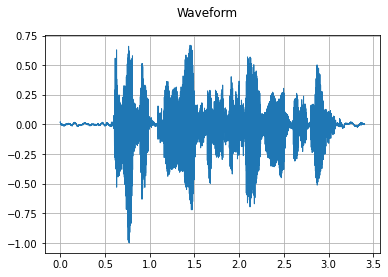

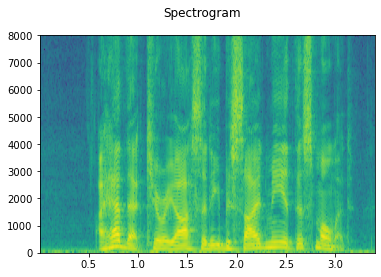

In [12]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [13]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

# Load audio from tar file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

# Load audio from S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_get_filelen at 0x0000024D147289D0>:
Traceback (most recent call last):
  File "C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\soundfile.py", line 1199, in vio_get_filelen
    file.seek(0, SEEK_END)
io.UnsupportedOperation: seek


RuntimeError: Error opening <urllib3.response.HTTPResponse object at 0x0000024D1B3E8A00>: Error in WAV file. No 'data' chunk marker.